In [34]:
#Importing Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [35]:
# Fetch Images

In [36]:
dirs = os.listdir('images/')
for dir in dirs:
    dir_path = os.path.join('images', dir)
    if os.path.isdir(dir_path):
        files = os.listdir(dir_path)
        print(dir, len(files))

daisy 764
rose 784
tulip 984
dandelion 1052
sunflower 733


In [37]:
### Load Images into Array as Datasets

In [38]:
base_dir = 'images/'
img_size = 180
batch = 32

In [39]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [40]:
flower_names = train_ds.class_names
num_classes = len(flower_names)
print(flower_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


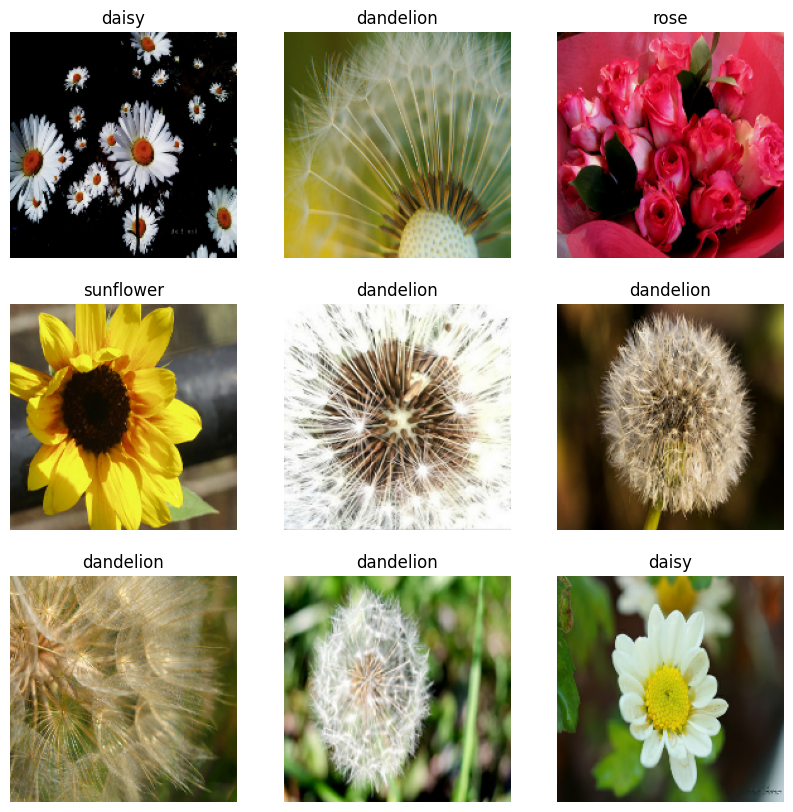

In [41]:
i = 0
images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [44]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [45]:
# Data Augmentation
# Flip Image

In [46]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/Users/nibesh/dev/MresAi/.mres/lib/python3.11/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


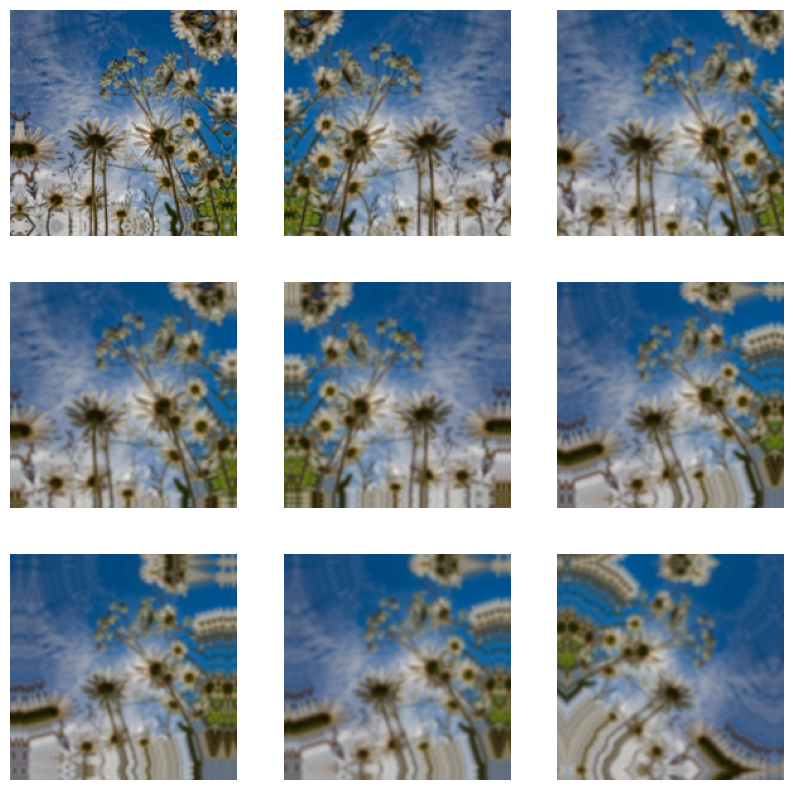

In [47]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [48]:
### Model Creation

In [52]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.4427 - loss: 1.3099 - val_accuracy: 0.5261 - val_loss: 1.1143
Epoch 2/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.5750 - loss: 1.0558 - val_accuracy: 0.6072 - val_loss: 0.9605
Epoch 3/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.6228 - loss: 0.9495 - val_accuracy: 0.6489 - val_loss: 0.9076
Epoch 4/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.6566 - loss: 0.8989 - val_accuracy: 0.6176 - val_loss: 1.0223
Epoch 5/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.6726 - loss: 0.8572 - val_accuracy: 0.6790 - val_loss: 0.8347
Epoch 6/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.6847 - loss: 0.8059 - val_accuracy: 0.6674 - val_loss: 0.8671
Epoch 7/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.7001 - loss: 0.7701 - val_accuracy: 0.6779 - val_loss: 0.8411
Epoch 8/25
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.7258 - loss: 0

In [57]:
# =========================
# Evaluate Accuracy
# =========================
loss, accuracy = model.evaluate(val_ds)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7335 - loss: 0.9038

Validation Accuracy: 73.35%


In [58]:
# =========================
# Predictions for Metrics
# =========================
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_logits = model.predict(val_ds)
y_pred = np.argmax(y_pred_logits, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [59]:
# =========================
# Precision, Recall, F1-score
# =========================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=flower_names))


Classification Report:
              precision    recall  f1-score   support

       daisy       0.71      0.80      0.75       143
   dandelion       0.83      0.75      0.79       200
        rose       0.84      0.43      0.57       159
   sunflower       0.68      0.87      0.77       148
       tulip       0.68      0.80      0.74       213

    accuracy                           0.73       863
   macro avg       0.75      0.73      0.72       863
weighted avg       0.75      0.73      0.73       863



In [60]:
# =========================
# Confusion Matrix
# =========================
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[114   7   3  11   8]
 [ 21 150   0  20   9]
 [ 14   4  69  12  60]
 [  5  11   0 129   3]
 [  7   8  10  17 171]]


In [61]:
# =========================
# AUC Score (One-vs-Rest)
# =========================
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_prob = tf.nn.softmax(y_pred_logits).numpy()

auc_scores = {}
for i, name in enumerate(flower_names):
    auc_scores[name] = roc_auc_score(y_true_bin[:, i], y_pred_prob[:, i])

print("\nAUC Scores:")
for cls, score in auc_scores.items():
    print(f"{cls}: {score:.4f}")


AUC Scores:
daisy: 0.9444
dandelion: 0.9642
rose: 0.9044
sunflower: 0.9642
tulip: 0.9171


In [23]:
def classify_image(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size = (180, 180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array, 0)
    
    predection = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predection[0])
    return 'The image belongs to '+ flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result) * 100)

In [24]:
classify_image('sample_images/5794835_d15905c7c8_n.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


'The image belongs to daisy with a score of 96.25541'

In [114]:
model.save('Flower_Recognization_Model.keras')